In [92]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from scipy.signal import find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve


In [88]:
trigger_file = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/sca_waveform.wfm'
trig = wfm2read(trigger_file)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (10* np.max(trig_y))

path = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/*.wfm'
files = glob(path)

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/sca_waveform.wfm starting at index 0 with step 1


In [84]:
def integrate_s2(file, s2_lowcut=0.5e-5, s2_upcut=1.5e-5):
    wf = wfm2read(file)
    t, V = wf[1], -wf[0]
    
    bs_lowcut = 2e-5
    bs_upcut = 4e-5
    baseline_window = (t > bs_lowcut) & (t < bs_upcut)
    baseline = np.mean(V[baseline_window])
    V -= baseline

    s2_window = (t > s2_lowcut) & (t < s2_upcut)
    area_s2 = np.trapz(V[s2_window], t[s2_window]) * 1e6 / 1e-3  # Convert to milivolts / microsec
    return area_s2, V, t

def plot_s2_integration(t, V, s2_lowcut, s2_upcut, trig_x = None, trig_y = None):

    plt.plot(t, V, label='SCA Waveform')
    if trig_x is not None and trig_y is not None:
        plt.plot(trig_x, trig_y, label='Trigger SCA', color='orange')

    plt.fill_betweenx(
        [0, 1],
        x1=s2_lowcut,
        x2=s2_upcut,
        color='green',
        alpha=0.3,
        label='S2 window'
    )
    plt.gca().set(xlabel='Time (s)', ylabel='Voltage (V)', title='SCA Waveform with Trigger')

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_1Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_11Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_13Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_3Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/w

[(-0.2, 0.5), (-1e-05, 2.2e-05)]

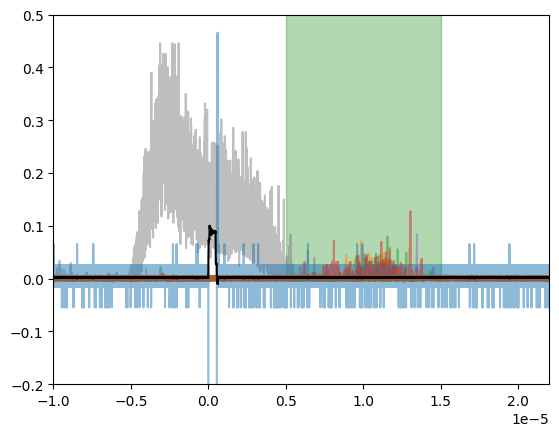

In [90]:
s2_lowcut = 0.5e-5
s2_upcut = 1.5e-5

areas_s2 = []
for f in files:
    as2, V, t = integrate_s2(f)
    areas_s2.append(as2)
    plt.plot(t, V, alpha=0.5, label='SCA Waveform')

plt.plot(trig_x, trig_y, label='Trigger SCA', color='black')
plt.fill_betweenx(
        [0, 1],
        x1=s2_lowcut, x2=s2_upcut,
        color='green', alpha=0.3, label='S2 window'
    )
plt.gca().set(ylim=(-0.2, 0.5), xlim=(-1e-5, 2.2e-5))

[Text(0.5, 0, 'S2 Area (mV*us)'),
 Text(0, 0.5, 'Counts'),
 Text(0.5, 1.0, 'S2 Area Distribution')]

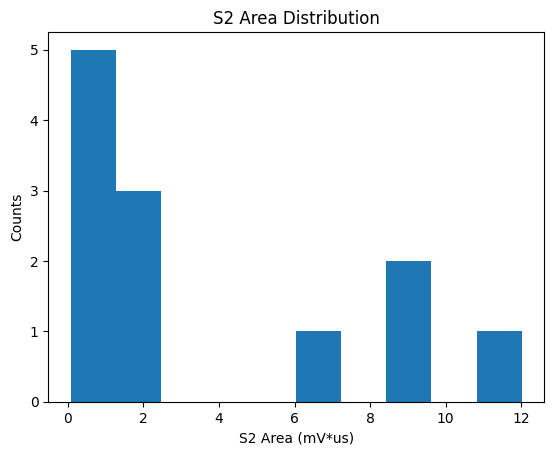

In [76]:
areas_s2 = np.array(areas_s2)
plt.hist(areas_s2[(areas_s2 > 0) & (areas_s2 < 6000)], )
plt.gca().set(xlabel='S2 Area (mV*us)', ylabel='Counts', title='S2 Area Distribution')

In [91]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_1Wfm.wfm starting at index 0 with step 1


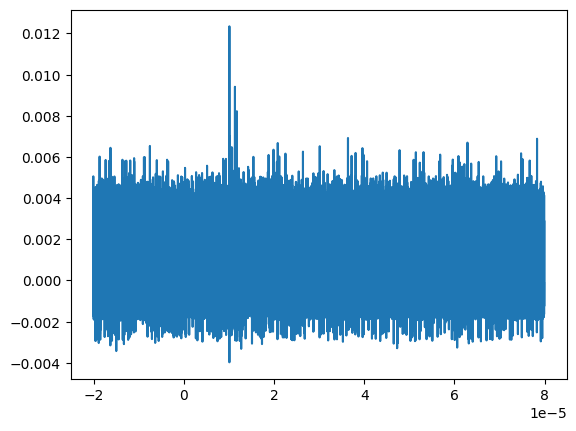

In [94]:
wf = wfm2read(files[0])
V, t = -wf[0], wf[1]
bs = baseline_als(V, lam=100, p=0.1)
V -= bs
plt.plot(t, V)
